In [2]:
import sys
import torch
import importlib

%matplotlib inline

sys.path.append('src')

import reversi

import numpy as np
import pylab as plt
import seaborn as sns
import time

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
sns.set()

import deepPlayer
import qFunction
importlib.reload(qFunction)

from memory import Memory
from qFunction import QFunction

import pickle
import plot

from plot import plot_win_rate
from plot import test_and_plot_win_rate

importlib.reload(deepPlayer)
importlib.reload(plot)

#変更を加えたいファイルはreversiから出してreload(クラス名)をすればよい

<module 'plot' from '/home/goto.k2/reinforce_reversi/plot.py'>

# train

In [3]:
day = "1028"
cond = 1

In [4]:
episode_num = 100
memory_size = 30 * episode_num
batch_size = 60

target_update = 5000

alpha = 0.2 #0でrandom experience replayと等価
beta = 0.7

memory = Memory(size = memory_size)
eps_decrease = 1 / 10000

dqn_player = deepPlayer.DQNPlayer("どきゅん太郎", memory, eps_decrease = eps_decrease, alpha = alpha, batch_size=batch_size, 
                                  beta = beta, use_IS=False, PER=False, cond = cond)

random_player = reversi.player.RandomPlayer("乱太郎")

DuelingDQN(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3_adv): Linear(in_features=128, out_features=64, bias=True)
  (fc3_v): Linear(in_features=128, out_features=1, bias=True)
)


## random

  5%|▍         | 998/20000 [00:15<05:23, 58.66it/s]

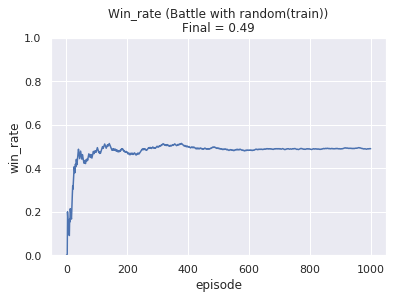

battle with random...


KeyboardInterrupt: 

In [5]:
random_train_num = 20000


plot_train = True
plot_test = True

for i in tqdm(range(random_train_num)):
    if np.random.random() < 0.5:
        white = dqn_player
        black = random_player
    else:
        white = random_player
        black = dqn_player
    game = reversi.Reversi(white, black)
    game.main_loop(print_game = False)

    if batch_size <= dqn_player.memory.counter: #memory数がバッチサイズ以下の時は学習しない
        dqn_player.q_function.train()
        
    if i % target_update == 0:
        dqn_player.q_function.update_target_network()
        
    if plot_train and i % 999 == 0 and i != 0:
        #訓練時勝率をプロット
        plot_win_rate(dqn_player, save_name = "./fig/{0}_cond{1}/{0}_cond{1}_{2}_train.pdf".format(day, cond, i))
        
    if plot_test and i % 999 == 0 and i != 0:
        #epsilon=0にして評価用勝率をplot
        test_and_plot_win_rate(dqn_player, save_name = "./fig/{0}_cond{1}/{0}_cond{1}_{2}_train.pdf".format(day, cond, i))

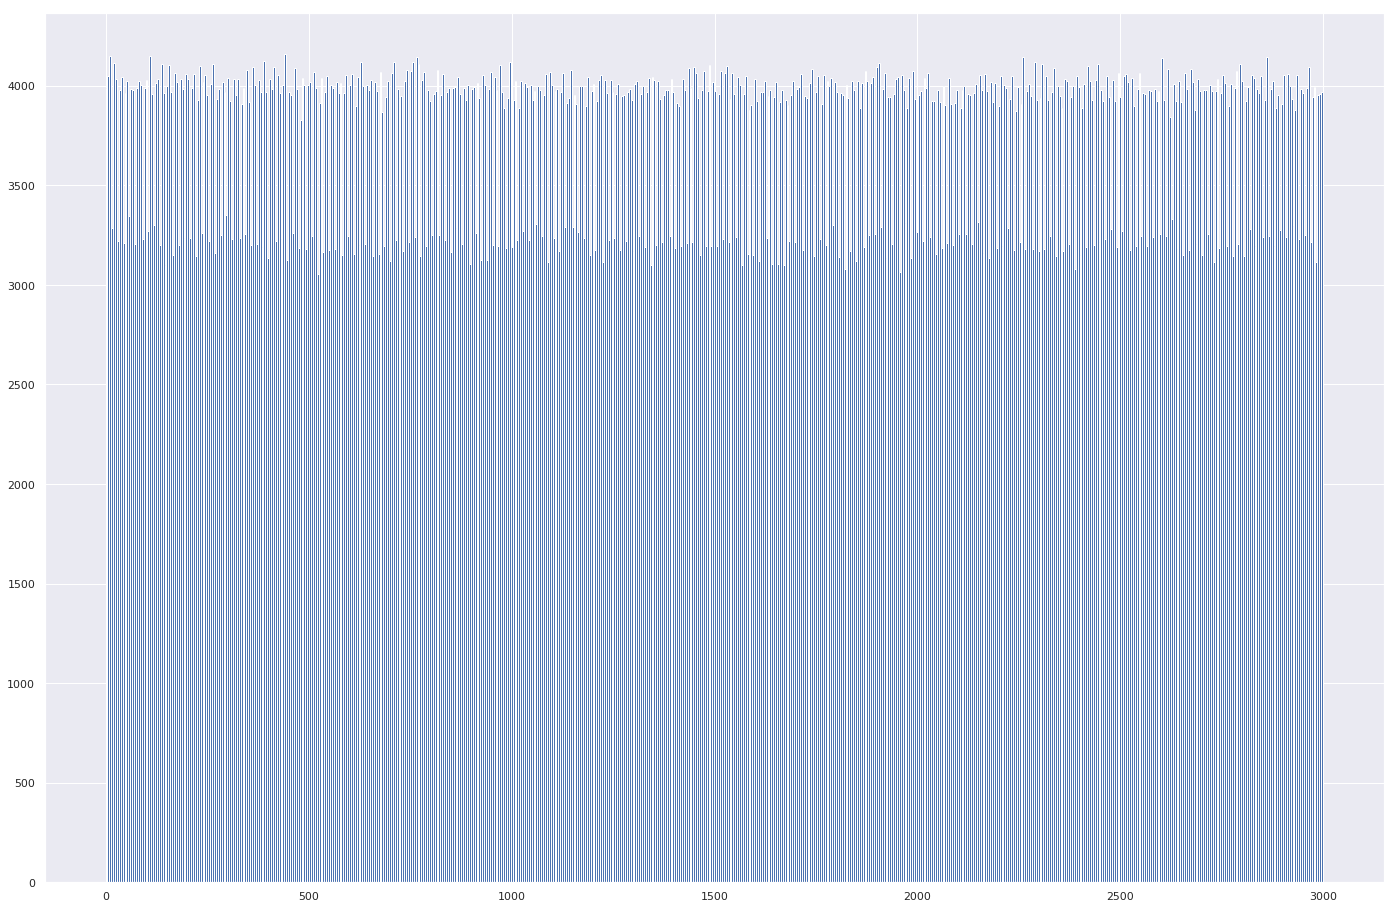

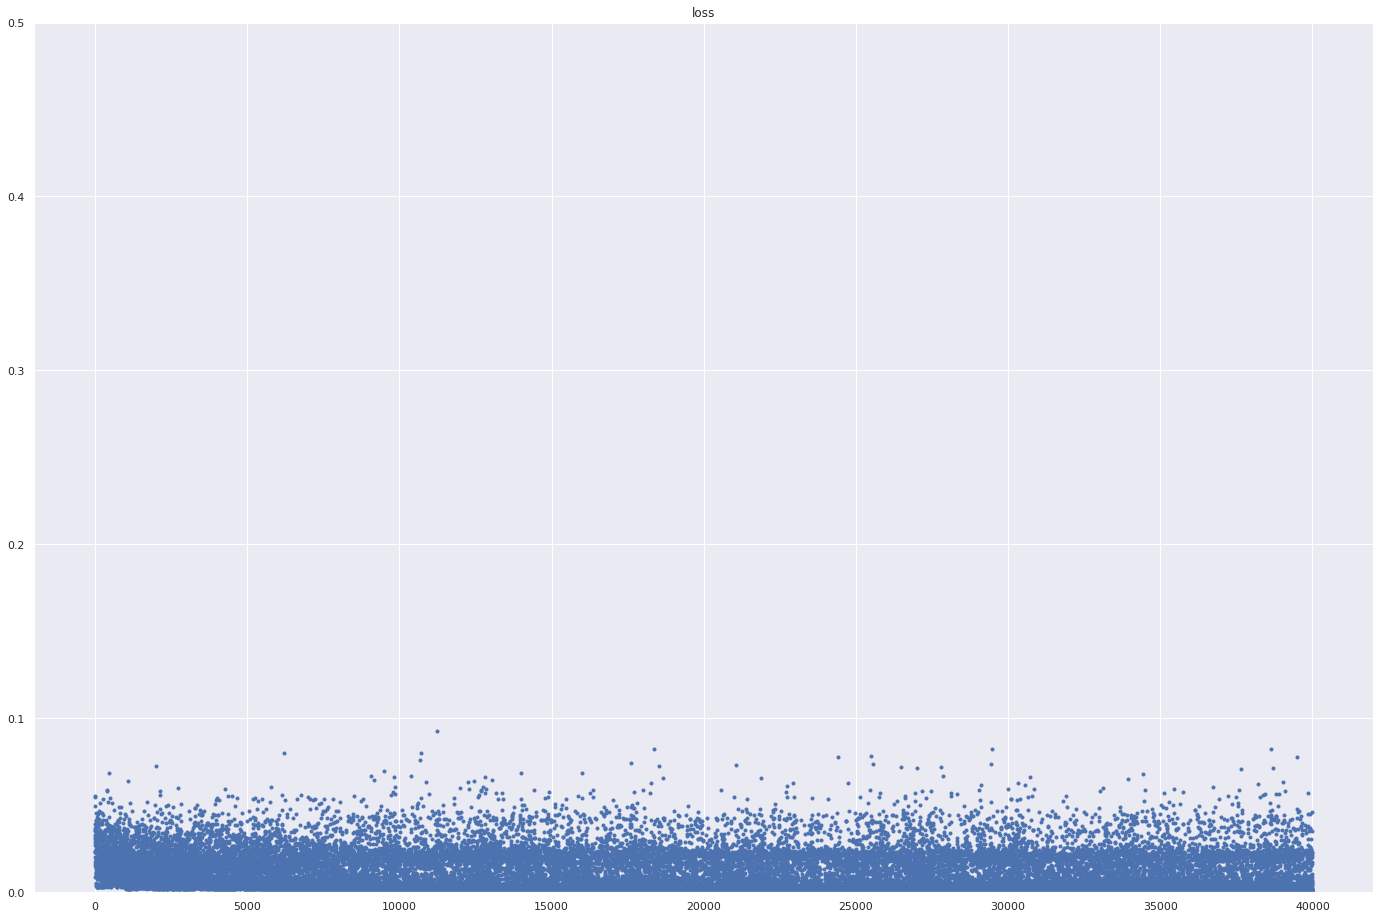

In [7]:
#replayの分布とlossの遷移を表示
plot.plot_dist_sample(dqn_player.q_function.ind_log)
plot.plot_loss(dqn_player.q_function.loss_log)

## own

In [3]:
enemy_memory = Memory(size = memory_size)
enemy_dqn_player = deepPlayer.DQNPlayer("敵太郎", enemy_memory, eps_decrease = eps_decrease)

In [ ]:
train_num = 5000

for i in tqdm(range(train_num)):
    if np.random.random() < 0.5:
        white = dqn_player
        black = enemy_dqn_player
    else:
        white = enemy_dqn_player
        black = dqn_player
    game = reversi.Reversi(white, black)
    game.main_loop(print_game = False)


    dqn_player.q_function.train()
    enemy_dqn_player.q_function.train()

In [ ]:
wininig_DQN = np.array(dqn_player.record) == 1

plt.grid(True)
plt.ylim(0, 1)
plt.title("win_rate (Battle with same structure)")
plt.plot(np.cumsum(wininig_DQN) / (np.arange(len(wininig_DQN)) + 1))
plt.show()

# check win_rate(Battle with random)

100%|██████████| 500/500 [00:09<00:00, 55.79it/s]


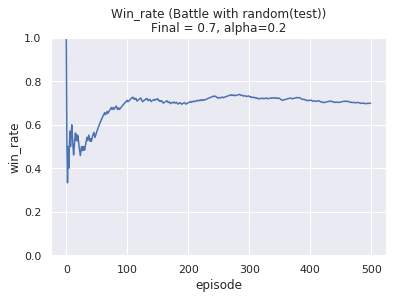

## check enemy win rate
同じ構造のネットワークと訓練した時は相手のネットワークの勝率も一応確認

In [ ]:
game_num = 2000

#train時レコードとepsilon退避
train_record = enemy_dqn_player.record
enemy_dqn_player.record = []

train_eps = enemy_dqn_player.eps
enemy_dqn_player.eps = 0 #greedy挙動のみ

train_memory = dqn_player.memory
dqn_player.memory = Memory(size=64)

for i in tqdm(range(game_num)):
    
    if np.random.random() < 0.5:
        white = random_player
        black = enemy_dqn_player
    else:
        white = enemy_dqn_player
        black = random_player
    game = reversi.Reversi(white, black)
    game.main_loop(print_game=False)
    


wining_DQN = np.array(enemy_dqn_player.record) == 1

plt.grid(True)
plt.ylim(0, 1)
final_win_rate = np.cumsum(wining_DQN)[len(np.cumsum(wining_DQN))-1]/len(wining_DQN)
plt.title("win_rate(Battle with random, final = {})".format(round(final_win_rate, 4)))
plt.xlabel("episode")
plt.ylabel("win_rate")
plt.plot(np.cumsum(wininig_DQN) / (np.arange(len(wininig_DQN)) + 1))


#recordを訓練用に復帰
enemy_dqn_player.record = train_record
enemy_dqn_player.eps = train_eps
enemy_dqn_player.memory = train_memory